<a href="https://colab.research.google.com/github/Mihishi/ECG-image-classification/blob/main/SCA_ECG_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
import os
import pandas as pd
!pip install -q gdown
import gdown


# Download dataset from public link

FILE_ID = "1OEk14Klk5WpMFNaNcUTHC-nSCnRRZZJu"
URL = f"https://drive.google.com/uc?id={FILE_ID}"

ZIP_NAME = "image-processing.zip"
LOCAL_DATA_DIR = "/content/extracted_data/"

print("Downloading dataset from public Google Drive...")

gdown.download(URL, ZIP_NAME, quiet=False)

# Extract dataset
!mkdir -p {LOCAL_DATA_DIR}
!unzip -q {ZIP_NAME} -d {LOCAL_DATA_DIR}
!rm {ZIP_NAME}

print(f"Dataset extracted to {LOCAL_DATA_DIR}")

# Load dataset
data_path = "/content/extracted_data/ECG_DATA/train"

images = []
labels = []

if not os.path.isdir(data_path):
    print(f"Error: Final data path not found: {data_path}. Check your zip's internal structure.")
else:
    for subfolder in os.listdir(data_path):

        subfolder_path = os.path.join(data_path, subfolder)

        if not os.path.isdir(subfolder_path):
            continue

        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)

    data = pd.DataFrame({'image': images, 'label': labels})

    print("Data loading successful!")
    print(f"Total images found: {len(data)}")
    print("\nSample Data:")
    print(data.head())

In [ ]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (2418, 2)
Validation set shape: (302, 2)
Test set shape: (303, 2)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (100, 100)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    cval=0,
)

ts_gen = ImageDataGenerator()


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 2418 validated image filenames belonging to 4 classes.
Found 302 validated image filenames belonging to 4 classes.
Found 303 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

class StopAt98Accuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.98 or logs.get('val_accuracy') >= 0.98:
            acc_type = "TRAINING" if logs.get('accuracy') >= 0.98 else "VALIDATION"
            print(f"\nReached 98% {acc_type} accuracy at epoch {epoch+1}. Stopping training!")
            self.model.stop_training = True

def build_improved_model(base_model, num_classes=4):
    base_model.trainable = True

    for layer in base_model.layers[:-10]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

callbacks = [
    StopAt98Accuracy(),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

In [ ]:
input_shape = (100, 100, 3)

# VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model_vgg16_improved = build_improved_model(base_model, num_classes=4)

history = model_vgg16_improved.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    callbacks=callbacks
)

accuracy_vgg16_improved = model_vgg16_improved.evaluate(valid_gen)[1]
print(f"Improved VGG16 Accuracy: {accuracy_vgg16_improved:.4f}")

I0000 00:00:1759689640.006008      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


I0000 00:00:1759689649.704713     130 service.cc:148] XLA service 0x7c2c640189b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759689649.705590     130 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759689650.347141     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/76 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.1797 - loss: 1.9806  

I0000 00:00:1759689656.388765     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.2743 - loss: 1.4924 - val_accuracy: 0.2318 - val_loss: 3.2580 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 749ms/step - accuracy: 0.3684 - loss: 1.3154 - val_accuracy: 0.2318 - val_loss: 13.3756 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 765ms/step - accuracy: 0.4608 - loss: 1.1579 - val_accuracy: 0.2318 - val_loss: 6.2847 - learning_rate: 1.0000e-04
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 745ms/step - accuracy: 0.4644 - loss: 1.1590 - val_accuracy: 0.4901 - val_loss: 1.6634 - learning_rate: 1.0000e-04
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 733ms/step - accuracy: 0.5483 - loss: 1.0300 - val_accuracy: 0.3311 - val_loss: 4.8062 - learning_rate: 1.0000e-04
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 729ms/step - accuracy: 0.6005 - loss: 0.9403 - val_accuracy: 0.2815 - val_loss: 13.2558 - learning_rate: 1.0000e-04
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 741ms/step - accuracy: 0.67


Generating predictions for classification report and confusion matrix...

CLASSIFICATION REPORT
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)     0.6419    1.0000    0.7819        95
     ECG Images of Patient that have History of MI (172x12=2064)     0.8421    0.6154    0.7111        52
ECG Images of Patient that have abnormal heartbeat (233x12=2796)     0.9000    0.5143    0.6545        70
                          Normal Person ECG Images (284x12=3408)     0.8289    0.7412    0.7826        85

                                                        accuracy                         0.7483       302
                                                       macro avg     0.8032    0.7177    0.7325       302
                                                    weighted avg     0.7888    0.7483    0.7404       302


CONFUSION MATRIX


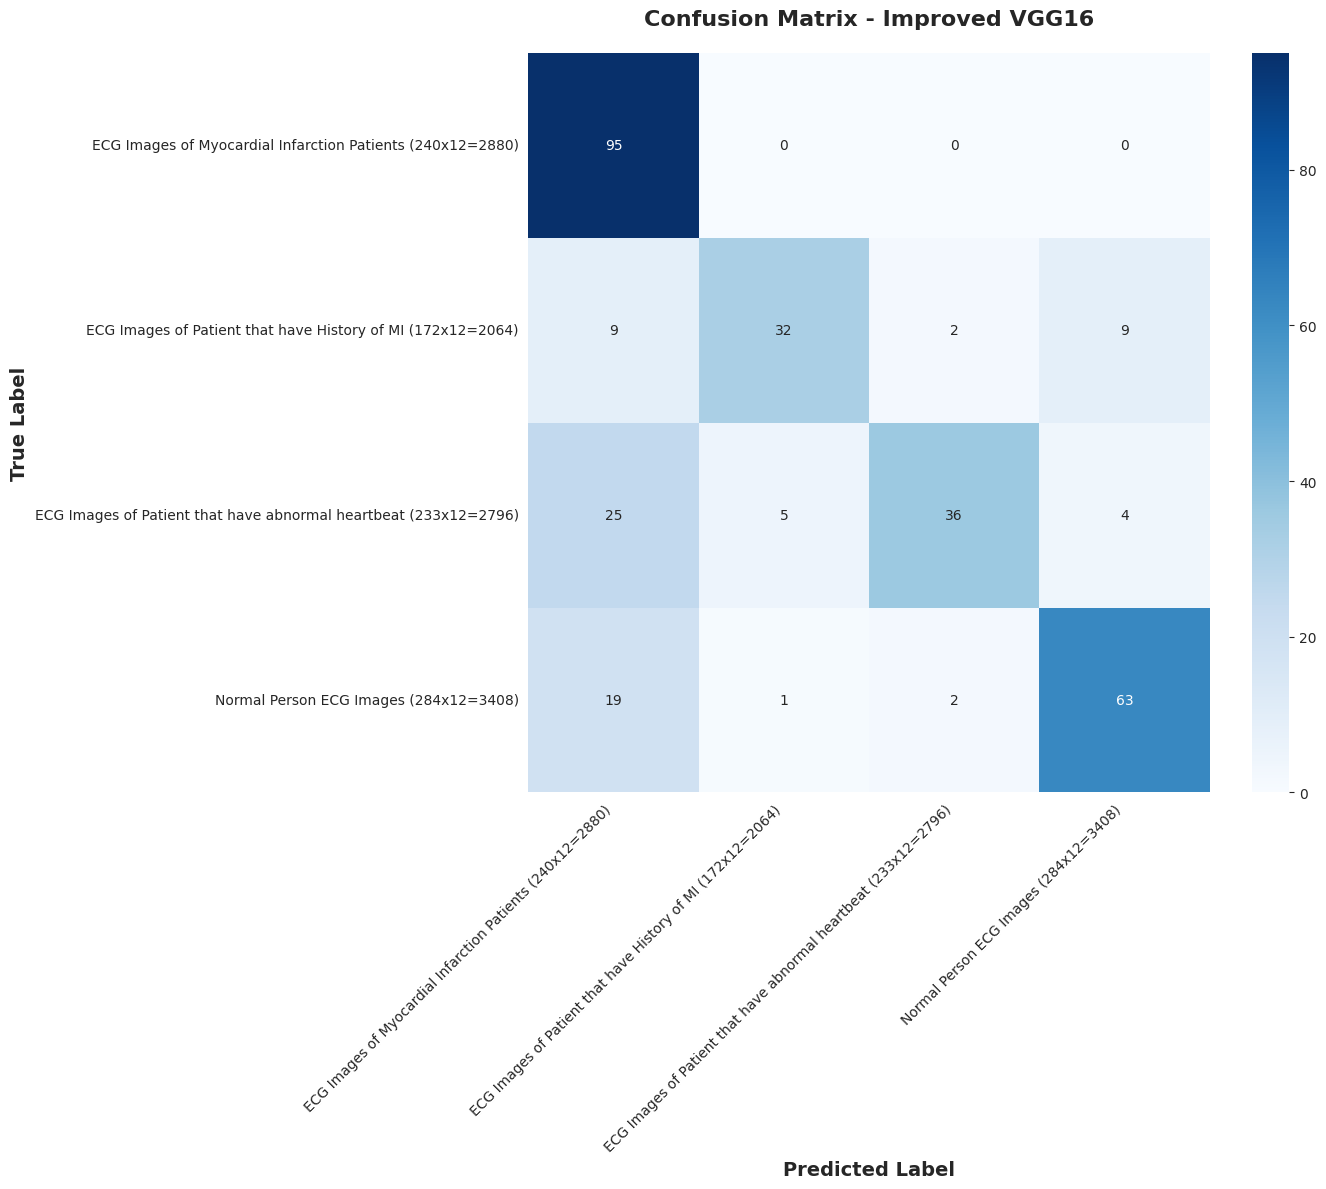


ADDITIONAL METRICS:
Accuracy: 0.7483
Weighted Precision: 0.7888
Weighted Recall: 0.7483
Weighted F1-Score: 0.7404

PER-CLASS ACCURACY ANALYSIS
ECG Images of Myocardial Infarction Patients (240x12=2880):  95/ 95 = 1.0000
ECG Images of Patient that have History of MI (172x12=2064):  32/ 52 = 0.6154
ECG Images of Patient that have abnormal heartbeat (233x12=2796):  36/ 70 = 0.5143
Normal Person ECG Images (284x12=3408):  63/ 85 = 0.7412

Best performing class: ECG Images of Myocardial Infarction Patients (240x12=2880) (1.0000)
Worst performing class: ECG Images of Patient that have abnormal heartbeat (233x12=2796) (0.5143)

TRAINING HISTORY PLOTS


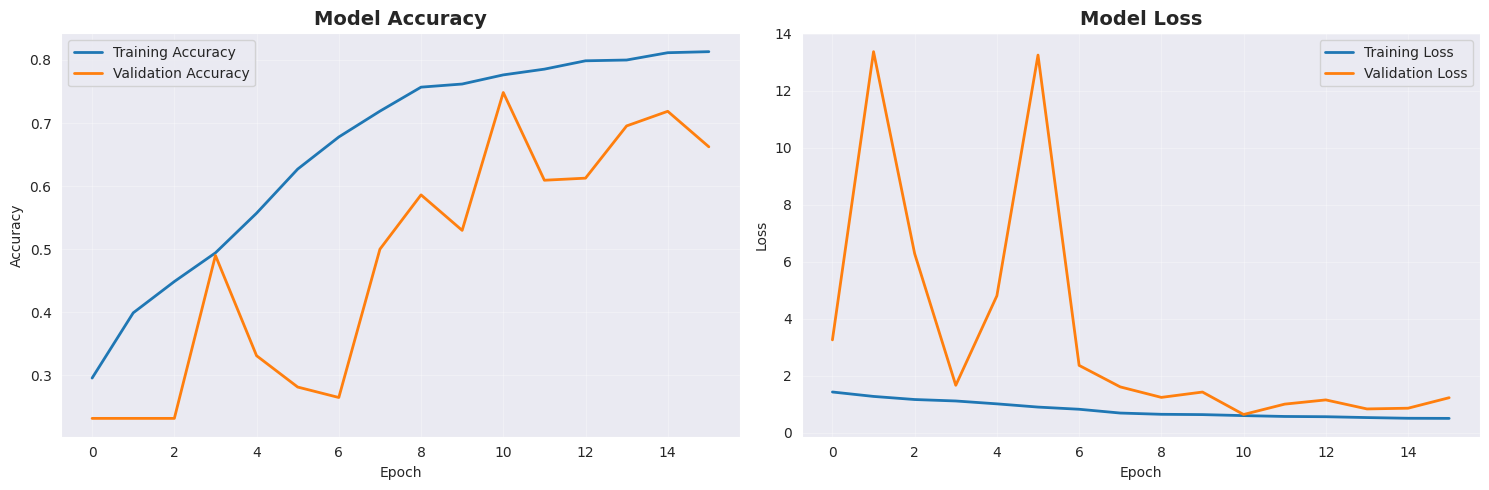


TRAINING SUMMARY
Final Validation Accuracy: 0.7483
Total Epochs Trained: 16
Final Training Accuracy: 0.8131
Final Validation Accuracy: 0.6623
Final Training Loss: 0.5021
Final Validation Loss: 1.2279


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\nGenerating predictions for classification report and confusion matrix...")

y_true = []
y_pred = []

valid_gen.reset()
for i in range(len(valid_gen)):
    X_batch, y_batch = valid_gen[i]
    y_true.extend(np.argmax(y_batch, axis=1))

    batch_pred = model_vgg16_improved.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(batch_pred, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
class_names = list(valid_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={'size': 10})
plt.title('Confusion Matrix - Improved VGG16', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nADDITIONAL METRICS:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

print("\n" + "="*60)
print("PER-CLASS ACCURACY ANALYSIS")
print("="*60)

class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_mask = y_true == i
    if np.sum(class_mask) > 0:
        class_correct = np.sum((y_pred[class_mask] == i))
        class_total = np.sum(class_mask)
        class_acc = class_correct / class_total
        class_accuracy[class_name] = class_acc
        print(f"{class_name:<20}: {class_correct:>3}/{class_total:>3} = {class_acc:.4f}")

if class_accuracy:
    best_class = max(class_accuracy, key=class_accuracy.get)
    worst_class = min(class_accuracy, key=class_accuracy.get)
    print(f"\nBest performing class: {best_class} ({class_accuracy[best_class]:.4f})")
    print(f"Worst performing class: {worst_class} ({class_accuracy[worst_class]:.4f})")

print("\n" + "="*60)
print("TRAINING HISTORY PLOTS")
print("="*60)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Final Validation Accuracy: {accuracy_vgg16_improved:.4f}")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

# VGG19

In [ ]:
from tensorflow.keras.applications import VGG19

base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
model_vgg19 = build_improved_model(base_model_vgg19, num_classes=4)
model_vgg19.fit(train_gen, validation_data=valid_gen, epochs=30, callbacks=callbacks)
accuracy_vgg19 = model_vgg19.evaluate(valid_gen)[1]
print(f"VGG19 Accuracy: {accuracy_vgg19:.4f}")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 67s 779ms/step - accuracy: 0.2489 - loss: 1.6120 - val_accuracy: 0.3444 - val_loss: 19.3231 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 741ms/step - accuracy: 0.3943 - loss: 1.2939 - val_accuracy: 0.2318 - val_loss: 18.6300 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 59s 774ms/step - accuracy: 0.4090 - loss: 1.2086 - val_accuracy: 0.3146 - val_loss: 11.8934 - learning_rate: 1.0000e-04
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 740ms/step - accuracy: 0.4658 - loss: 1.1386 - val_accuracy: 0.3146 - val_loss: 6.9050 - learning_rate: 1.0000e-04
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 763ms/step - accuracy: 0.5138 - loss: 1.0543 - val_accuracy: 0.3146 - val_loss: 8.5635 - learning_rate: 1.0000e-04
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 746ms/step - accuracy: 0.5568 - loss: 1.0267 - val_accuracy: 0.4404 - val_loss: 1.3108 - learning_rate: 1.0000e-04
Epoc

In [ ]:
def evaluate_model(model, valid_gen, model_name="Model", history=None):

    print(f"\nGenerating predictions for {model_name}...")

    y_true = []
    y_pred = []

    valid_gen.reset()
    for i in range(len(valid_gen)):
        X_batch, y_batch = valid_gen[i]
        y_true.extend(np.argmax(y_batch, axis=1))

        batch_pred = model.predict(X_batch, verbose=0)
        y_pred.extend(np.argmax(batch_pred, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)

    print("\n" + "="*60)
    print(f"CLASSIFICATION REPORT - {model_name.upper()}")
    print("="*60)
    class_names = list(valid_gen.class_indices.keys())
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    print("\n" + "="*60)
    print(f"CONFUSION MATRIX - {model_name.upper()}")
    print("="*60)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={'size': 10})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\nADDITIONAL METRICS:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")

    print("\n" + "="*60)
    print(f"PER-CLASS ACCURACY ANALYSIS - {model_name.upper()}")
    print("="*60)

    class_accuracy = {}
    for i, class_name in enumerate(class_names):
        class_mask = y_true == i
        if np.sum(class_mask) > 0:
            class_correct = np.sum((y_pred[class_mask] == i))
            class_total = np.sum(class_mask)
            class_acc = class_correct / class_total
            class_accuracy[class_name] = class_acc
            print(f"{class_name:<20}: {class_correct:>3}/{class_total:>3} = {class_acc:.4f}")

    if class_accuracy:
        best_class = max(class_accuracy, key=class_accuracy.get)
        worst_class = min(class_accuracy, key=class_accuracy.get)
        print(f"\nBest performing class: {best_class} ({class_accuracy[best_class]:.4f})")
        print(f"Worst performing class: {worst_class} ({class_accuracy[worst_class]:.4f})")

    if history is not None:
        print("\n" + "="*60)
        print(f"TRAINING HISTORY PLOTS - {model_name.upper()}")
        print("="*60)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        plt.title(f'{model_name} Model Accuracy', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
        plt.title(f'{model_name} Model Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("\n" + "="*60)
        print(f"TRAINING SUMMARY - {model_name.upper()}")
        print("="*60)
        print(f"Final Validation Accuracy: {accuracy:.4f}")
        print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
        print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
        print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
        print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

        if hasattr(history, 'model') and history.model.stop_training:
            print("Training was stopped early by callback")
        else:
            print("Training completed all epochs")
    else:
        print(f"\nNote: Training history not provided. Skipping history plots and summary.")

    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'class_accuracy': class_accuracy,
        'confusion_matrix': cm,
        'class_names': class_names
    }


Generating predictions for VGG19...

CLASSIFICATION REPORT - VGG19
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)     0.7653    0.7895    0.7772        95
     ECG Images of Patient that have History of MI (172x12=2064)     0.7419    0.4423    0.5542        52
ECG Images of Patient that have abnormal heartbeat (233x12=2796)     1.0000    0.5286    0.6916        70
                          Normal Person ECG Images (284x12=3408)     0.5809    0.9294    0.7149        85

                                                        accuracy                         0.7086       302
                                                       macro avg     0.7720    0.6724    0.6845       302
                                                    weighted avg     0.7638    0.7086    0.7014       302


CONFUSION MATRIX - VGG19


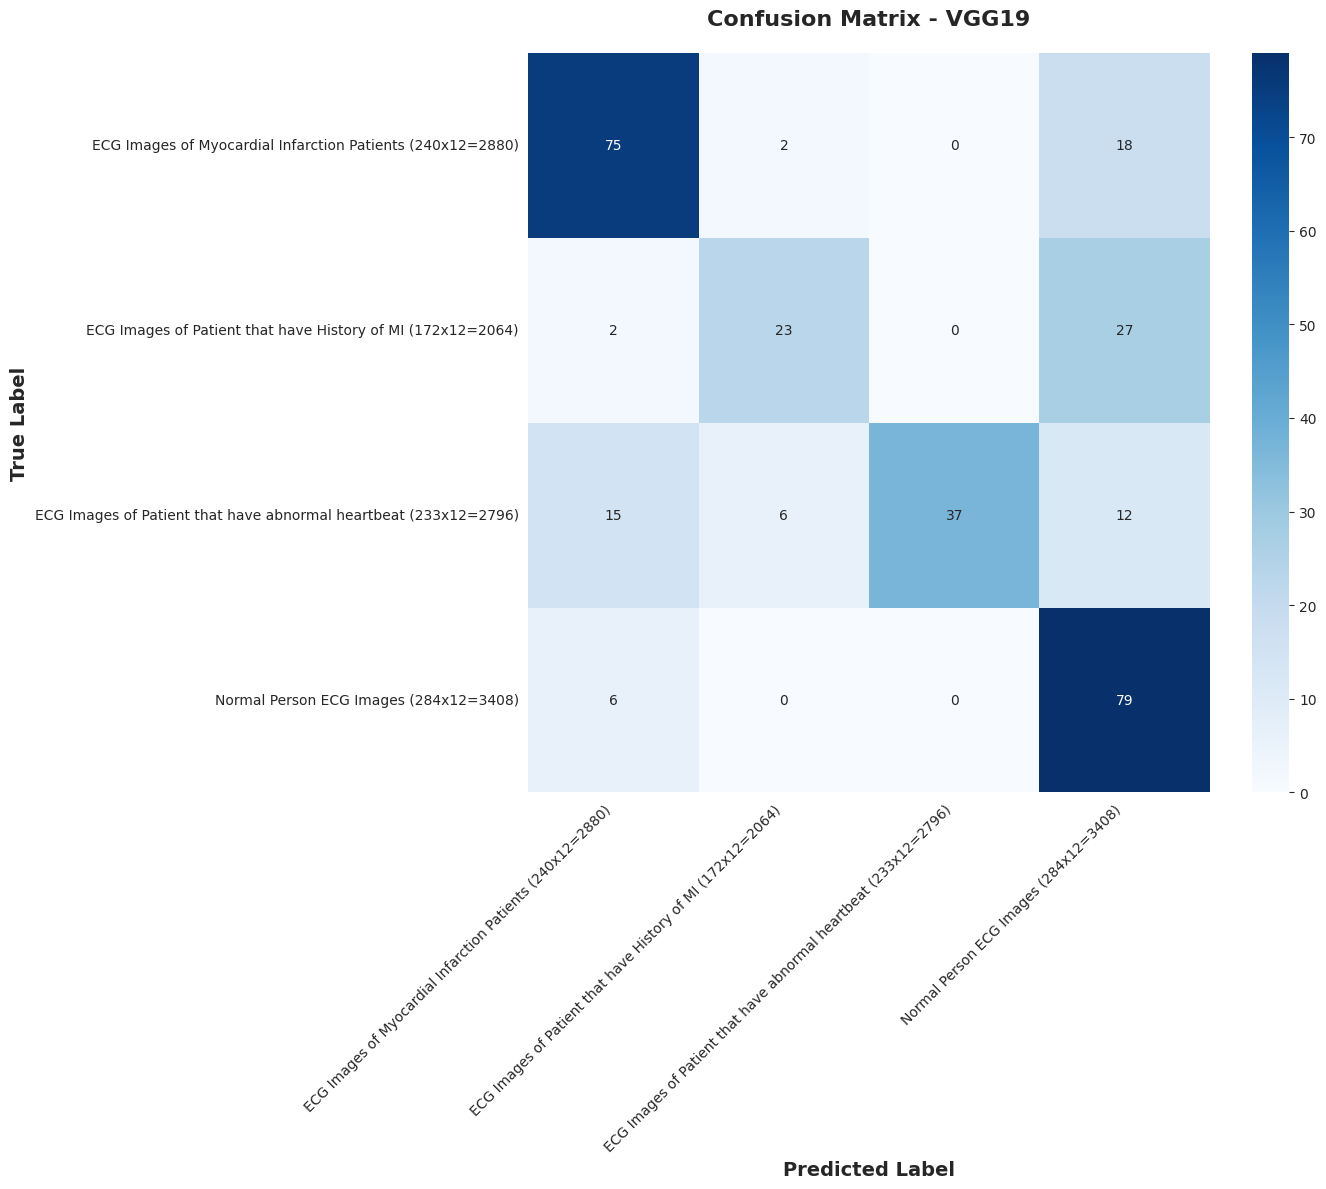


ADDITIONAL METRICS:
Accuracy: 0.7086
Weighted Precision: 0.7638
Weighted Recall: 0.7086
Weighted F1-Score: 0.7014

PER-CLASS ACCURACY ANALYSIS - VGG19
ECG Images of Myocardial Infarction Patients (240x12=2880):  75/ 95 = 0.7895
ECG Images of Patient that have History of MI (172x12=2064):  23/ 52 = 0.4423
ECG Images of Patient that have abnormal heartbeat (233x12=2796):  37/ 70 = 0.5286
Normal Person ECG Images (284x12=3408):  79/ 85 = 0.9294

Best performing class: Normal Person ECG Images (284x12=3408) (0.9294)
Worst performing class: ECG Images of Patient that have History of MI (172x12=2064) (0.4423)

Note: Training history not provided. Skipping history plots and summary.


{'y_true': array([2, 2, 3, 3, 3, 1, 2, 1, 2, 0, 0, 3, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3,
        0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 1, 3, 3, 0, 1, 3, 2, 1, 2, 3, 0, 3,
        1, 0, 0, 1, 2, 2, 0, 0, 2, 3, 2, 0, 2, 2, 2, 3, 0, 3, 2, 2, 3, 0,
        0, 2, 3, 2, 0, 3, 0, 3, 2, 2, 1, 2, 3, 0, 2, 3, 2, 2, 1, 0, 0, 0,
        0, 0, 2, 0, 0, 2, 3, 0, 2, 3, 2, 3, 2, 0, 2, 0, 1, 1, 3, 3, 1, 1,
        3, 0, 2, 0, 0, 0, 1, 2, 1, 1, 3, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2,
        2, 3, 0, 0, 3, 0, 1, 3, 3, 3, 1, 1, 3, 2, 0, 2, 3, 0, 1, 1, 1, 0,
        0, 0, 3, 0, 2, 3, 3, 1, 1, 0, 3, 0, 0, 0, 0, 3, 0, 3, 1, 0, 2, 3,
        0, 3, 0, 2, 3, 1, 2, 2, 2, 0, 3, 0, 0, 2, 3, 0, 0, 2, 1, 0, 2, 0,
        0, 3, 0, 0, 3, 0, 2, 1, 0, 0, 1, 3, 1, 3, 0, 3, 3, 1, 0, 3, 3, 3,
        3, 2, 2, 0, 0, 3, 0, 1, 0, 3, 0, 0, 3, 0, 3, 2, 1, 2, 1, 2, 0, 3,
        3, 1, 3, 1, 3, 3, 1, 1, 1, 0, 2, 2, 3, 1, 3, 0, 3, 0, 0, 1, 0, 1,
        3, 3, 2, 3, 0, 2, 1, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 0, 1, 0, 3,
        0, 3, 0, 0, 2, 2, 3,

In [ ]:
evaluate_model(model_vgg19, valid_gen, "VGG19")

# ResNet101

In [ ]:
from tensorflow.keras.applications import ResNet101

base_model_resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
model_resnet101 = build_improved_model(base_model_resnet101, num_classes=4)
model_resnet101.fit(train_gen, validation_data=valid_gen, epochs=30, callbacks=callbacks)
accuracy_resnet101 = model_resnet101.evaluate(valid_gen)[1]
print(f"ResNet101 Accuracy: {accuracy_resnet101:.4f}")

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 102s 975ms/step - accuracy: 0.3223 - loss: 1.8026 - val_accuracy: 0.4205 - val_loss: 1.2679 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 718ms/step - accuracy: 0.3871 - loss: 1.5637 - val_accuracy: 0.4901 - val_loss: 1.1944 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 728ms/step - accuracy: 0.4147 - loss: 1.4907 - val_accuracy: 0.5497 - val_loss: 1.0999 - learning_rate: 1.0000e-04
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 738ms/step - accuracy: 0.4386 - loss: 1.3569 - val_accuracy: 0.5000 - val_loss: 1.1212 - learning_rate: 1.0000e-04
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 54s 717ms/step - accuracy: 0.4560 - loss: 1.3589 - val_accuracy: 0.5232 - val_loss: 1.0659 - learning_rate: 1.0000e-04
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 746ms/step - accuracy: 0.4722 - loss: 1.2436 - val_accuracy: 0.5199 - val_loss: 1.0499 - learning_rate: 1.0000e-04
Epoc


Generating predictions for resnet101...

CLASSIFICATION REPORT - RESNET101
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)     0.5649    0.7789    0.6549        95
     ECG Images of Patient that have History of MI (172x12=2064)     0.6552    0.3654    0.4691        52
ECG Images of Patient that have abnormal heartbeat (233x12=2796)     0.7089    0.8000    0.7517        70
                          Normal Person ECG Images (284x12=3408)     0.6032    0.4471    0.5135        85

                                                        accuracy                         0.6192       302
                                                       macro avg     0.6330    0.5978    0.5973       302
                                                    weighted avg     0.6246    0.6192    0.6055       302


CONFUSION MATRIX - RESNET101


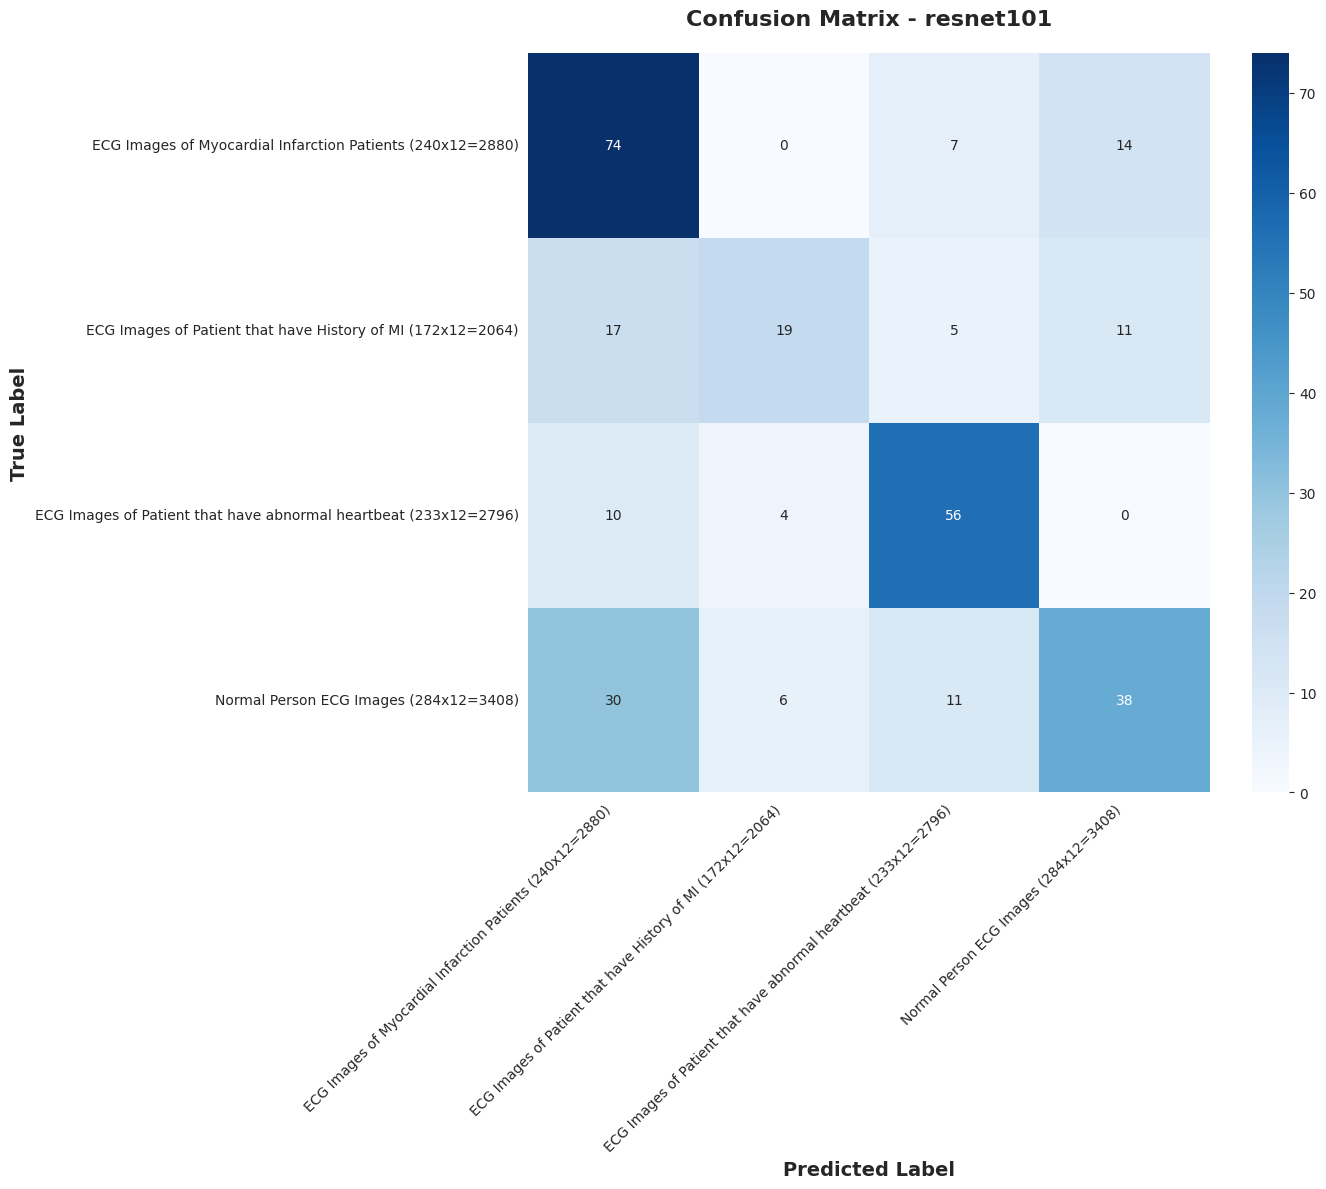


ADDITIONAL METRICS:
Accuracy: 0.6192
Weighted Precision: 0.6246
Weighted Recall: 0.6192
Weighted F1-Score: 0.6055

PER-CLASS ACCURACY ANALYSIS - RESNET101
ECG Images of Myocardial Infarction Patients (240x12=2880):  74/ 95 = 0.7789
ECG Images of Patient that have History of MI (172x12=2064):  19/ 52 = 0.3654
ECG Images of Patient that have abnormal heartbeat (233x12=2796):  56/ 70 = 0.8000
Normal Person ECG Images (284x12=3408):  38/ 85 = 0.4471

Best performing class: ECG Images of Patient that have abnormal heartbeat (233x12=2796) (0.8000)
Worst performing class: ECG Images of Patient that have History of MI (172x12=2064) (0.3654)

Note: Training history not provided. Skipping history plots and summary.


{'y_true': array([2, 2, 3, 3, 3, 1, 2, 1, 2, 0, 0, 3, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3,
        0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 1, 3, 3, 0, 1, 3, 2, 1, 2, 3, 0, 3,
        1, 0, 0, 1, 2, 2, 0, 0, 2, 3, 2, 0, 2, 2, 2, 3, 0, 3, 2, 2, 3, 0,
        0, 2, 3, 2, 0, 3, 0, 3, 2, 2, 1, 2, 3, 0, 2, 3, 2, 2, 1, 0, 0, 0,
        0, 0, 2, 0, 0, 2, 3, 0, 2, 3, 2, 3, 2, 0, 2, 0, 1, 1, 3, 3, 1, 1,
        3, 0, 2, 0, 0, 0, 1, 2, 1, 1, 3, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2,
        2, 3, 0, 0, 3, 0, 1, 3, 3, 3, 1, 1, 3, 2, 0, 2, 3, 0, 1, 1, 1, 0,
        0, 0, 3, 0, 2, 3, 3, 1, 1, 0, 3, 0, 0, 0, 0, 3, 0, 3, 1, 0, 2, 3,
        0, 3, 0, 2, 3, 1, 2, 2, 2, 0, 3, 0, 0, 2, 3, 0, 0, 2, 1, 0, 2, 0,
        0, 3, 0, 0, 3, 0, 2, 1, 0, 0, 1, 3, 1, 3, 0, 3, 3, 1, 0, 3, 3, 3,
        3, 2, 2, 0, 0, 3, 0, 1, 0, 3, 0, 0, 3, 0, 3, 2, 1, 2, 1, 2, 0, 3,
        3, 1, 3, 1, 3, 3, 1, 1, 1, 0, 2, 2, 3, 1, 3, 0, 3, 0, 0, 1, 0, 1,
        3, 3, 2, 3, 0, 2, 1, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 0, 1, 0, 3,
        0, 3, 0, 0, 2, 2, 3,

In [ ]:
evaluate_model(model_resnet101, valid_gen, "resnet101")

# MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
model_mobilenet = build_improved_model(base_model_mobilenet, num_classes=4)
model_mobilenet.fit(train_gen, validation_data=valid_gen, epochs=30, callbacks=callbacks)
accuracy_mobilenet = model_mobilenet.evaluate(valid_gen)[1]
print(f"MobileNetV2 Accuracy: {accuracy_mobilenet:.4f}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


E0000 00:00:1759692393.001507     131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759692393.199828     131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


70/76 ━━━━━━━━━━━━━━━━━━━━ 4s 723ms/step - accuracy: 0.2278 - loss: 2.0892

E0000 00:00:1759692449.074494     131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759692449.276389     131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


76/76 ━━━━━━━━━━━━━━━━━━━━ 88s 949ms/step - accuracy: 0.2302 - loss: 2.0737 - val_accuracy: 0.3046 - val_loss: 1.4820 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 60s 792ms/step - accuracy: 0.3166 - loss: 1.6636 - val_accuracy: 0.3510 - val_loss: 1.3775 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 60s 793ms/step - accuracy: 0.3276 - loss: 1.6080 - val_accuracy: 0.3477 - val_loss: 1.3439 - learning_rate: 1.0000e-04
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 60s 785ms/step - accuracy: 0.3525 - loss: 1.5486 - val_accuracy: 0.3411 - val_loss: 1.3513 - learning_rate: 1.0000e-04
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 60s 783ms/step - accuracy: 0.3275 - loss: 1.5513 - val_accuracy: 0.3245 - val_loss: 1.3165 - learning_rate: 1.0000e-04
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 796ms/step - accuracy: 0.3165 - loss: 1.5176 - val_accuracy: 0.3245 - val_loss: 1.3644 - learning_rate: 1.0000e-04
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 60s 791ms/step - accuracy: 0.35


Generating predictions for mobilenet...

CLASSIFICATION REPORT - MOBILENET
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)     0.3524    0.7789    0.4852        95
     ECG Images of Patient that have History of MI (172x12=2064)     0.0000    0.0000    0.0000        52
ECG Images of Patient that have abnormal heartbeat (233x12=2796)     0.7500    0.0429    0.0811        70
                          Normal Person ECG Images (284x12=3408)     0.3295    0.3412    0.3353        85

                                                        accuracy                         0.3510       302
                                                       macro avg     0.3580    0.2907    0.2254       302
                                                    weighted avg     0.3774    0.3510    0.2658       302


CONFUSION MATRIX - MOBILENET


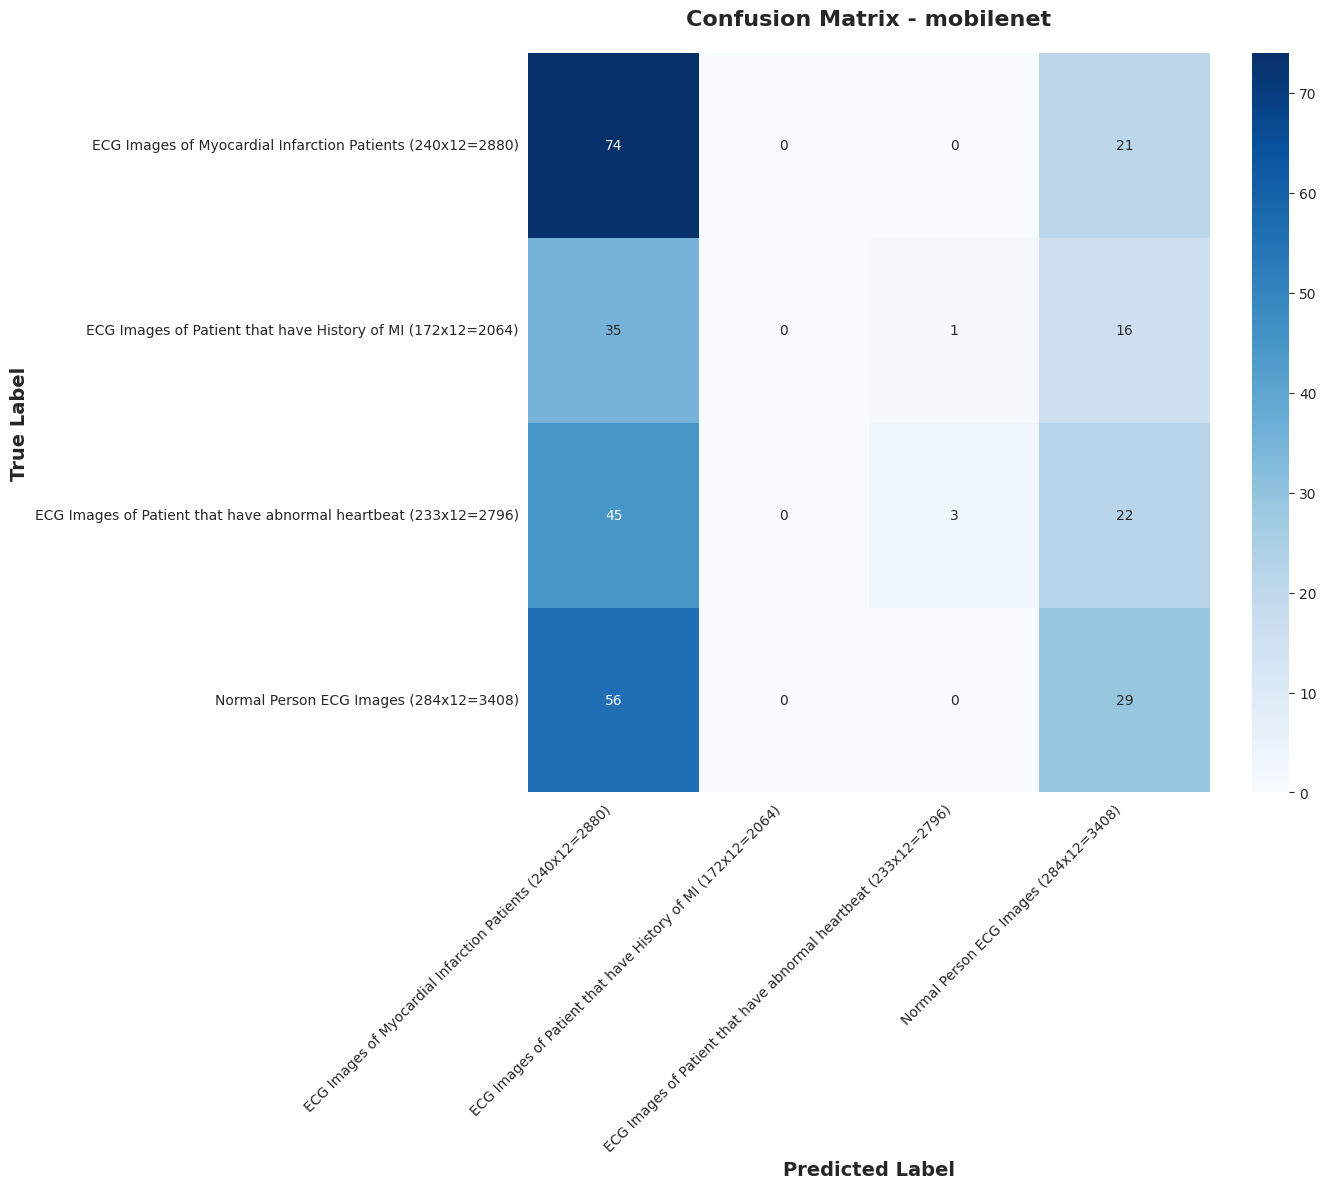


ADDITIONAL METRICS:
Accuracy: 0.3510
Weighted Precision: 0.3774
Weighted Recall: 0.3510
Weighted F1-Score: 0.2658

PER-CLASS ACCURACY ANALYSIS - MOBILENET
ECG Images of Myocardial Infarction Patients (240x12=2880):  74/ 95 = 0.7789
ECG Images of Patient that have History of MI (172x12=2064):   0/ 52 = 0.0000
ECG Images of Patient that have abnormal heartbeat (233x12=2796):   3/ 70 = 0.0429
Normal Person ECG Images (284x12=3408):  29/ 85 = 0.3412

Best performing class: ECG Images of Myocardial Infarction Patients (240x12=2880) (0.7789)
Worst performing class: ECG Images of Patient that have History of MI (172x12=2064) (0.0000)

Note: Training history not provided. Skipping history plots and summary.


{'y_true': array([2, 2, 3, 3, 3, 1, 2, 1, 2, 0, 0, 3, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3,
        0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 1, 3, 3, 0, 1, 3, 2, 1, 2, 3, 0, 3,
        1, 0, 0, 1, 2, 2, 0, 0, 2, 3, 2, 0, 2, 2, 2, 3, 0, 3, 2, 2, 3, 0,
        0, 2, 3, 2, 0, 3, 0, 3, 2, 2, 1, 2, 3, 0, 2, 3, 2, 2, 1, 0, 0, 0,
        0, 0, 2, 0, 0, 2, 3, 0, 2, 3, 2, 3, 2, 0, 2, 0, 1, 1, 3, 3, 1, 1,
        3, 0, 2, 0, 0, 0, 1, 2, 1, 1, 3, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2,
        2, 3, 0, 0, 3, 0, 1, 3, 3, 3, 1, 1, 3, 2, 0, 2, 3, 0, 1, 1, 1, 0,
        0, 0, 3, 0, 2, 3, 3, 1, 1, 0, 3, 0, 0, 0, 0, 3, 0, 3, 1, 0, 2, 3,
        0, 3, 0, 2, 3, 1, 2, 2, 2, 0, 3, 0, 0, 2, 3, 0, 0, 2, 1, 0, 2, 0,
        0, 3, 0, 0, 3, 0, 2, 1, 0, 0, 1, 3, 1, 3, 0, 3, 3, 1, 0, 3, 3, 3,
        3, 2, 2, 0, 0, 3, 0, 1, 0, 3, 0, 0, 3, 0, 3, 2, 1, 2, 1, 2, 0, 3,
        3, 1, 3, 1, 3, 3, 1, 1, 1, 0, 2, 2, 3, 1, 3, 0, 3, 0, 0, 1, 0, 1,
        3, 3, 2, 3, 0, 2, 1, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 0, 1, 0, 3,
        0, 3, 0, 0, 2, 2, 3,

In [ ]:
evaluate_model(model_mobilenet, valid_gen, "mobilenet")

# EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model_efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
model_efficientnetb0 = build_improved_model(base_model_efficientnetb0, num_classes=4)
model_efficientnetb0.fit(train_gen, validation_data=valid_gen, epochs=30, callbacks=callbacks)
accuracy_efficientnetb0 = model_efficientnetb0.evaluate(valid_gen)[1]
print(f"EfficientNetB0 Accuracy: {accuracy_efficientnetb0:.4f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3189 - loss: 1.7520 - val_accuracy: 0.4338 - val_loss: 1.3201 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 804ms/step - accuracy: 0.3996 - loss: 1.4981 - val_accuracy: 0.4603 - val_loss: 1.2226 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 802ms/step - accuracy: 0.4135 - loss: 1.4052 - val_accuracy: 0.5397 - val_loss: 1.1552 - learning_rate: 1.0000e-04
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 60s 789ms/step - accuracy: 0.4420 - loss: 1.2997 - val_accuracy: 0.5364 - val_loss: 1.1164 - learning_rate: 1.0000e-04
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 810ms/step - accuracy: 0.4734 - loss: 1.2539 - val_accuracy: 0.5762 - val_loss: 1.0440 - learning_rate: 1.0000e-04
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 804ms/step - accuracy: 0.5045 - loss: 1.1858 - val_accuracy: 0.5265 - val_loss: 1.1239 - learning_rate: 1.0000e-04
Epoch 7/3


Generating predictions for efficientnetb0...

CLASSIFICATION REPORT - EFFICIENTNETB0
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)     0.7204    0.7053    0.7128        95
     ECG Images of Patient that have History of MI (172x12=2064)     0.4390    0.6923    0.5373        52
ECG Images of Patient that have abnormal heartbeat (233x12=2796)     0.8333    0.4286    0.5660        70
                          Normal Person ECG Images (284x12=3408)     0.6484    0.6941    0.6705        85

                                                        accuracy                         0.6358       302
                                                       macro avg     0.6603    0.6301    0.6216       302
                                                    weighted avg     0.6779    0.6358    0.6366       302


CONFUSION MATRIX - EFFICIENTNETB0


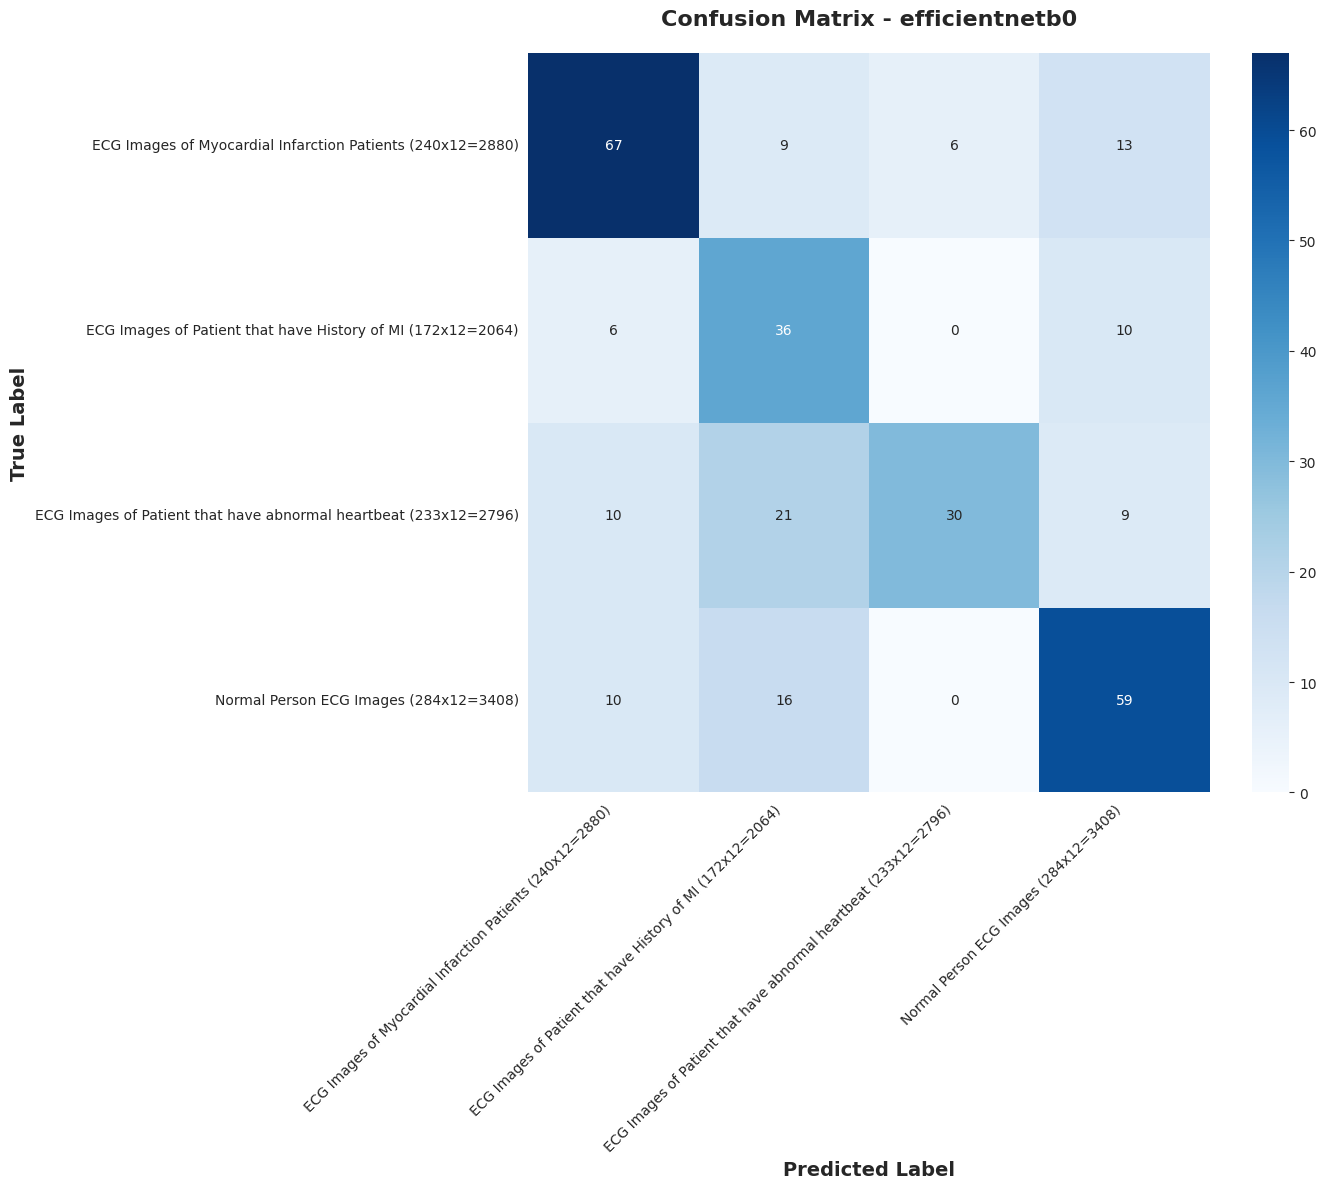


ADDITIONAL METRICS:
Accuracy: 0.6358
Weighted Precision: 0.6779
Weighted Recall: 0.6358
Weighted F1-Score: 0.6366

PER-CLASS ACCURACY ANALYSIS - EFFICIENTNETB0
ECG Images of Myocardial Infarction Patients (240x12=2880):  67/ 95 = 0.7053
ECG Images of Patient that have History of MI (172x12=2064):  36/ 52 = 0.6923
ECG Images of Patient that have abnormal heartbeat (233x12=2796):  30/ 70 = 0.4286
Normal Person ECG Images (284x12=3408):  59/ 85 = 0.6941

Best performing class: ECG Images of Myocardial Infarction Patients (240x12=2880) (0.7053)
Worst performing class: ECG Images of Patient that have abnormal heartbeat (233x12=2796) (0.4286)

Note: Training history not provided. Skipping history plots and summary.


{'y_true': array([2, 2, 3, 3, 3, 1, 2, 1, 2, 0, 0, 3, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3,
        0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 1, 3, 3, 0, 1, 3, 2, 1, 2, 3, 0, 3,
        1, 0, 0, 1, 2, 2, 0, 0, 2, 3, 2, 0, 2, 2, 2, 3, 0, 3, 2, 2, 3, 0,
        0, 2, 3, 2, 0, 3, 0, 3, 2, 2, 1, 2, 3, 0, 2, 3, 2, 2, 1, 0, 0, 0,
        0, 0, 2, 0, 0, 2, 3, 0, 2, 3, 2, 3, 2, 0, 2, 0, 1, 1, 3, 3, 1, 1,
        3, 0, 2, 0, 0, 0, 1, 2, 1, 1, 3, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2,
        2, 3, 0, 0, 3, 0, 1, 3, 3, 3, 1, 1, 3, 2, 0, 2, 3, 0, 1, 1, 1, 0,
        0, 0, 3, 0, 2, 3, 3, 1, 1, 0, 3, 0, 0, 0, 0, 3, 0, 3, 1, 0, 2, 3,
        0, 3, 0, 2, 3, 1, 2, 2, 2, 0, 3, 0, 0, 2, 3, 0, 0, 2, 1, 0, 2, 0,
        0, 3, 0, 0, 3, 0, 2, 1, 0, 0, 1, 3, 1, 3, 0, 3, 3, 1, 0, 3, 3, 3,
        3, 2, 2, 0, 0, 3, 0, 1, 0, 3, 0, 0, 3, 0, 3, 2, 1, 2, 1, 2, 0, 3,
        3, 1, 3, 1, 3, 3, 1, 1, 1, 0, 2, 2, 3, 1, 3, 0, 3, 0, 0, 1, 0, 1,
        3, 3, 2, 3, 0, 2, 1, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 0, 1, 0, 3,
        0, 3, 0, 0, 2, 2, 3,

In [ ]:
evaluate_model(model_efficientnetb0, valid_gen, "efficientnetb0")

# EfficientNetB1

In [ ]:
from tensorflow.keras.applications import EfficientNetB1

base_model_efficientnetb1 = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)
model_efficientnetb1 = build_improved_model(base_model_efficientnetb1, num_classes=4)
model_efficientnetb1.fit(train_gen, validation_data=valid_gen, epochs=30, callbacks=callbacks)
accuracy_efficientnetb1 = model_efficientnetb1.evaluate(valid_gen)[1]
print(f"EfficientNetB1 Accuracy: {accuracy_efficientnetb1:.4f}")

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.2781 - loss: 1.8121 - val_accuracy: 0.2715 - val_loss: 1.3662 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 732ms/step - accuracy: 0.3677 - loss: 1.5424 - val_accuracy: 0.4338 - val_loss: 1.3087 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 742ms/step - accuracy: 0.3883 - loss: 1.4268 - val_accuracy: 0.3675 - val_loss: 1.2989 - learning_rate: 1.0000e-04
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 731ms/step - accuracy: 0.4180 - loss: 1.3605 - val_accuracy: 0.3742 - val_loss: 1.2703 - learning_rate: 1.0000e-04
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 727ms/step - accuracy: 0.4485 - loss: 1.3093 - val_accuracy: 0.3377 - val_loss: 1.3223 - learning_rate: 1.0000e-04
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 734ms/step - accuracy: 0.4339 - loss: 1.2802 - val_accuracy: 0.3841 - val_loss: 1.2733 - learning_rate: 1.0000e-04
Epoch 7/3

# EfficientNetB2

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

base_model_efficientnetb2 = EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)
model_efficientnetb2 = build_improved_model(base_model_efficientnetb2, num_classes=4)
model_efficientnetb2.fit(train_gen, validation_data=valid_gen, epochs=30, callbacks=callbacks)
accuracy_efficientnetb2 = model_efficientnetb2.evaluate(valid_gen)[1]
print(f"EfficientNetB2 Accuracy: {accuracy_efficientnetb2:.4f}")

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.3172 - loss: 1.7963 - val_accuracy: 0.4272 - val_loss: 1.2524 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 728ms/step - accuracy: 0.3645 - loss: 1.5772 - val_accuracy: 0.4470 - val_loss: 1.2004 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 729ms/step - accuracy: 0.3876 - loss: 1.4302 - val_accuracy: 0.4470 - val_loss: 1.2148 - learning_rate: 1.0000e-04
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 746ms/step - accuracy: 0.4438 - loss: 1.3317 - val_accuracy: 0.5199 - val_loss: 1.2363 - learning_rate: 1.0000e-04
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 742ms/step - accuracy: 0.4443 - loss: 1.2975 - val_accuracy: 0.4801 - val_loss: 1.3452 - learning_rate: 1.0000e-04
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 730ms/step - accuracy: 0.4407 - loss: 1.3001 - val_accuracy: 0.4669 - val_loss: 1.4172 - learning_rate: 2.0000e-05
Epoch 7/3

In [ ]:
!pip install vit-keras transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    cval=0,
)

ts_gen = ImageDataGenerator()


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 2418 validated image filenames belonging to 4 classes.
Found 302 validated image filenames belonging to 4 classes.
Found 303 validated image filenames belonging to 4 classes.


# ViT-B16

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vit-b16 (Functional)            │ (None, 768)            │    85,798,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,327,812 (329.31 MB)

 Trainable params: 86,326,276 (329.31 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.2373 - loss: 2.1721 - val_accuracy: 0.1722 - val_loss: 1.8617 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2656 - loss: 2.0098 - val_accuracy: 0.2318 - val_loss: 1.7867 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2685 - loss: 1.9689 - val_accuracy: 0.2815 - val_loss: 1.5128 - learning_rate: 1.0000e-04
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.2561 - loss: 1.9773 - val_accuracy: 0.1722 - val_loss: 1.5295 - learning_rate: 1.0000e-04
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2646 - loss: 1.9340 - val_accuracy: 0.1722 - val_loss: 1.4489 - learning_rate: 1.0000e-04
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2696 - loss: 1.8323 - val_accuracy: 0.2318 - val_loss: 1.7584 - learning_rate: 1.0000e-04
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2882 - loss

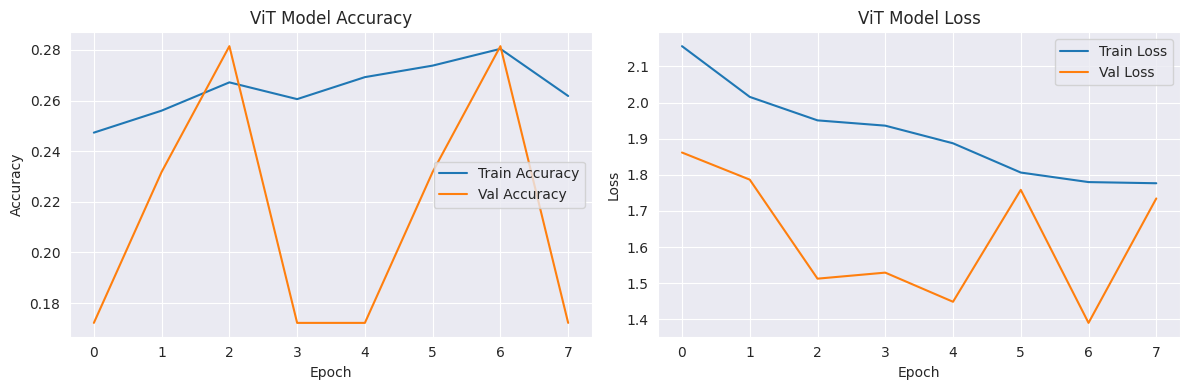

In [ ]:
import tensorflow as tf
from vit_keras import vit

base_model_vit = vit.vit_b16(
    image_size=224,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

def create_vit_model(base_model, num_classes):
    base_model.trainable = True

    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = base_model(inputs)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

num_classes = len(train_gen.class_indices)
model_vit = create_vit_model(base_model_vit, num_classes)

model_vit.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_vit.summary()

history_vit = model_vit.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    callbacks=callbacks
)

accuracy_vit = model_vit.evaluate(valid_gen)[1]
print(f"\nViT Validation Accuracy: {accuracy_vit:.4f}")

test_loss, test_accuracy = model_vit.evaluate(test_gen)
print(f"ViT Test Accuracy: {test_accuracy:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_vit.history['accuracy'], label='Train Accuracy')
plt.plot(history_vit.history['val_accuracy'], label='Val Accuracy')
plt.title('ViT Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_vit.history['loss'], label='Train Loss')
plt.plot(history_vit.history['val_loss'], label='Val Loss')
plt.title('ViT Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# vit_b32

353253686/353253686 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vit-b32 (Functional)            │ (None, 768)            │    87,455,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,984,388 (335.63 MB)

 Trainable params: 87,982,852 (335.63 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.2490 - loss: 2.1348 - val_accuracy: 0.1722 - val_loss: 1.5156 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 991ms/step - accuracy: 0.2403 - loss: 2.0093 - val_accuracy: 0.1722 - val_loss: 1.7006 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 75s 988ms/step - accuracy: 0.2723 - loss: 1.9191 - val_accuracy: 0.2318 - val_loss: 1.4303 - learning_rate: 1.0000e-04
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 998ms/step - accuracy: 0.2384 - loss: 1.9192 - val_accuracy: 0.3146 - val_loss: 1.7177 - learning_rate: 1.0000e-04
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.2750 - loss: 1.7840 - val_accuracy: 0.3146 - val_loss: 1.5762 - learning_rate: 1.0000e-04
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 998ms/step - accuracy: 0.2816 - loss: 1.7728 - val_accuracy: 0.2318 - val_loss: 1.4510 - learning_rate: 1.0000e-04
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 993ms/step - accuracy

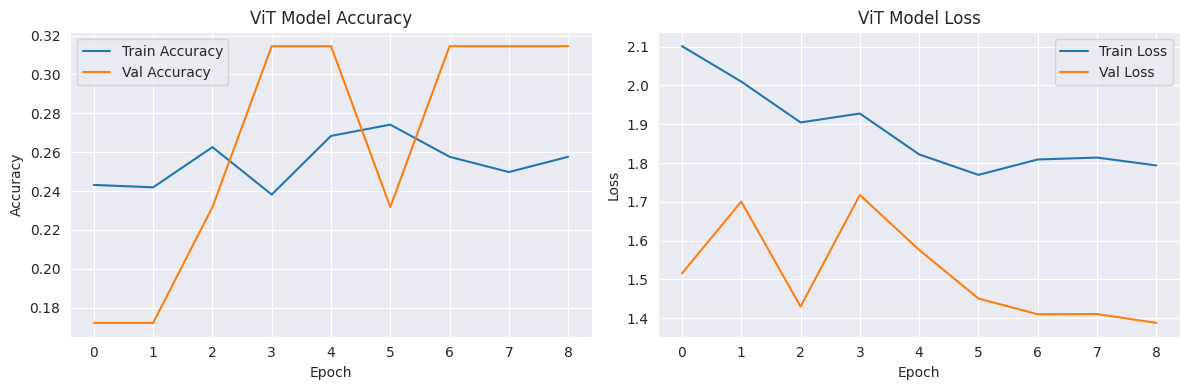

In [ ]:
base_model_vit = vit.vit_b32(
    image_size=224,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

def create_vit_model(base_model, num_classes):
    base_model.trainable = True

    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = base_model(inputs)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

num_classes = len(train_gen.class_indices)
model_vit = create_vit_model(base_model_vit, num_classes)

model_vit.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_vit.summary()

history_vit = model_vit.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    callbacks=callbacks
)

accuracy_vit = model_vit.evaluate(valid_gen)[1]
print(f"\nViT Validation Accuracy: {accuracy_vit:.4f}")

test_loss, test_accuracy = model_vit.evaluate(test_gen)
print(f"ViT Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_vit.history['accuracy'], label='Train Accuracy')
plt.plot(history_vit.history['val_accuracy'], label='Val Accuracy')
plt.title('ViT Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_vit.history['loss'], label='Train Loss')
plt.plot(history_vit.history['val_loss'], label='Val Loss')
plt.title('ViT Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()